In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 3.2 MB/s 
     |████████████████████████████████| 9.8 MB 36.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


If you are working locally or you do not have access to my Drive, be sure of having the following directory contents:

```
|- ..
|- assignment1.ipynb
|- outputs/
|- energydata_complete.csv
```

Remember to change the basepath with your desired destination. The basepath point to the above file tree structure.



# Assignment 1

## Matteo De Francesco

In this notebook we are going to cover the task of the _assignment 1_.

We will fit an ARMA model on a time series and predict the future values of it, both in the assumption of stationarity of the time series and not.

# Stationary

## Imports

In [ ]:
import os
import pandas as pdou
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pickle
import collections
import pmdarima as pm

from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm


sns.set_theme(style="darkgrid")

plt.rcParams["figure.figsize"] = (13,8)
plt.rcParams["figure.dpi"] = 140

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
basepath = "/content/drive/MyDrive/LEZIONI AA 2020 21/ISPR/assignments/assignment1"

df = pd.read_csv(os.path.join(basepath, "energydata_complete.csv"))


df

date  Appliances  lights         T1       RH_1  \
0      2016-01-11 17:00:00          60      30  19.890000  47.596667   
1      2016-01-11 17:10:00          60      30  19.890000  46.693333   
2      2016-01-11 17:20:00          50      30  19.890000  46.300000   
3      2016-01-11 17:30:00          50      40  19.890000  46.066667   
4      2016-01-11 17:40:00          60      40  19.890000  46.333333   
...                    ...         ...     ...        ...        ...   
19730  2016-05-27 17:20:00         100       0  25.566667  46.560000   
19731  2016-05-27 17:30:00          90       0  25.500000  46.500000   
19732  2016-05-27 17:40:00         270      10  25.500000  46.596667   
19733  2016-05-27 17:50:00         420      10  25.500000  46.990000   
19734  2016-05-27 18:00:00         430      10  25.500000  46.600000   

              T2       RH_2         T3       RH_3         T4  ...         T9  \
0      19.200000  44.790000  19.790000  44.730000  19.000000  ...  17.033333   
1      19.200000  44.722500  19.790000  44.790000  19.000000  ...  17.066667   
2      19.200000  44.626667  19.790000  44.933333  18.926667  ...  17.000000   
3      19.200000  44.590000  19.790000  45.000000  18.890000  ...  17.000000   
4      19.200000  44.530000  19.790000  45.000000  18.890000  ...  17.000000   
...          ...        ...        ...        ...        ...  ...        ...   
19730  25.890000  42.025714  27.200000  41.163333  24.700000  ...  23.200000   
19731  25.754000  42.080000  27.133333  41.223333  24.700000  ...  23.200000   
19732  25.628571  42.768571  27.050000  41.690000  24.700000  ...  23.200000   
19733  25.414000  43.036000  26.890000  41.290000  24.700000  ...  23.200000   
19734  25.264286  42.971429  26.823333  41.156667  24.700000  ...  23.200000   

          RH_9      T_out  Press_mm_hg     RH_out  Windspeed  Visibility  \
0      45.5300   6.600000        733.5  92.000000   7.000000   63.000000   
1      45.5600   6.483333        733.6  92.000000   6.666667   59.166667   
2      45.5000   6.366667        733.7  92.000000   6.333333   55.333333   
3      45.4000   6.250000        733.8  92.000000   6.000000   51.500000   
4      45.4000   6.133333        733.9  92.000000   5.666667   47.666667   
...        ...        ...          ...        ...        ...         ...   
19730  46.7900  22.733333        755.2  55.666667   3.333333   23.666667   
19731  46.7900  22.600000        755.2  56.000000   3.500000   24.500000   
19732  46.7900  22.466667        755.2  56.333333   3.666667   25.333333   
19733  46.8175  22.333333        755.2  56.666667   3.833333   26.166667   
19734  46.8450  22.200000        755.2  57.000000   4.000000   27.000000   

       Tdewpoint        rv1        rv2  
0       5.300000  13.275433  13.275433  
1       5.200000  18.606195  18.606195  
2       5.100000  28.642668  28.642668  
3       5.000000  45.410389  45.410389  
4       4.900000  10.084097  10.084097  
...          ...        ...        ...  
19730  13.333333  43.096812  43.096812  
19731  13.300000  49.282940  49.282940  
19732  13.266667  29.199117  29.199117  
19733  13.233333   6.322784   6.322784  
19734  13.200000  34.118851  34.118851  

[19735 rows x 29 columns]

Filter out all the columns, leave only date column and Appliances column. Sort by date

In [ ]:
df["date"] = pd.to_datetime(df["date"])

df = df.iloc[:, 0:2]

df = df.sort_values(by="date")

df

date  Appliances
0     2016-01-11 17:00:00          60
1     2016-01-11 17:10:00          60
2     2016-01-11 17:20:00          50
3     2016-01-11 17:30:00          50
4     2016-01-11 17:40:00          60
...                   ...         ...
19730 2016-05-27 17:20:00         100
19731 2016-05-27 17:30:00          90
19732 2016-05-27 17:40:00         270
19733 2016-05-27 17:50:00         420
19734 2016-05-27 18:00:00         430

[19735 rows x 2 columns]

## Data visualization

To check for stationarity of our time series, let's look before into the plot of the _Appliances_ values and the distribution of the data under an histogram representation

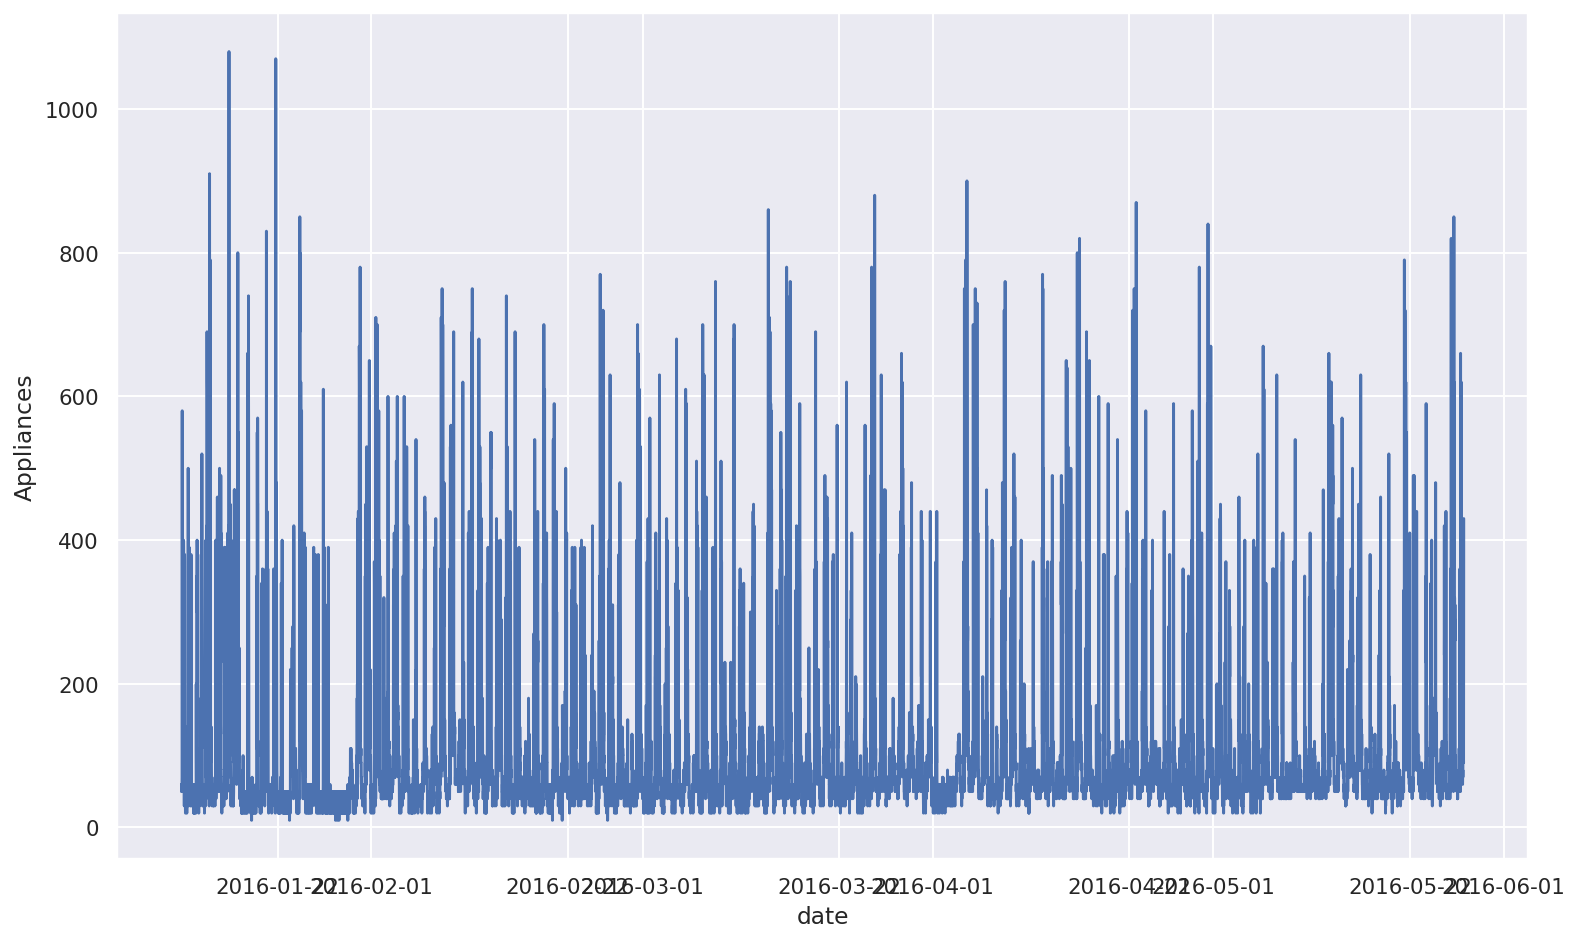

In [ ]:
sns.lineplot(x="date", y="Appliances", data=df)

Count number of unique values in Appliances columns for a better histogram representation

In [ ]:
num_bins = len(df.Appliances.unique())

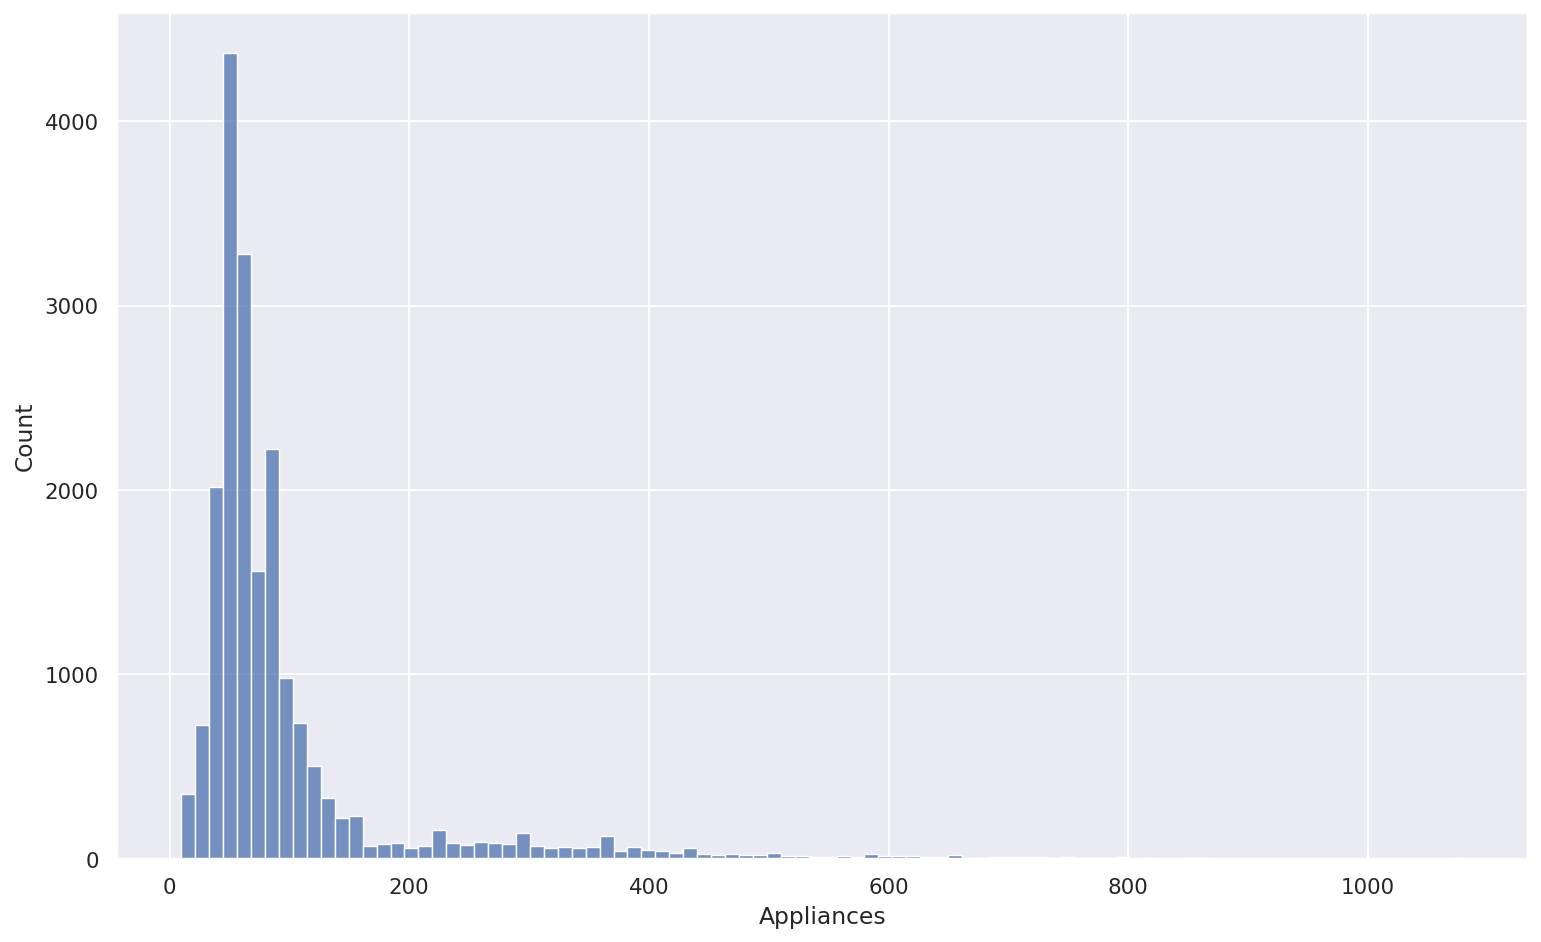

In [ ]:
sns.histplot(x="Appliances", data=df, bins=num_bins)

From the histogram plot the series does not seem to be gaussian distributed.  
There seems to be a peak and a decreasing trend on both sides, but we can verify better via a kernel density estimation.

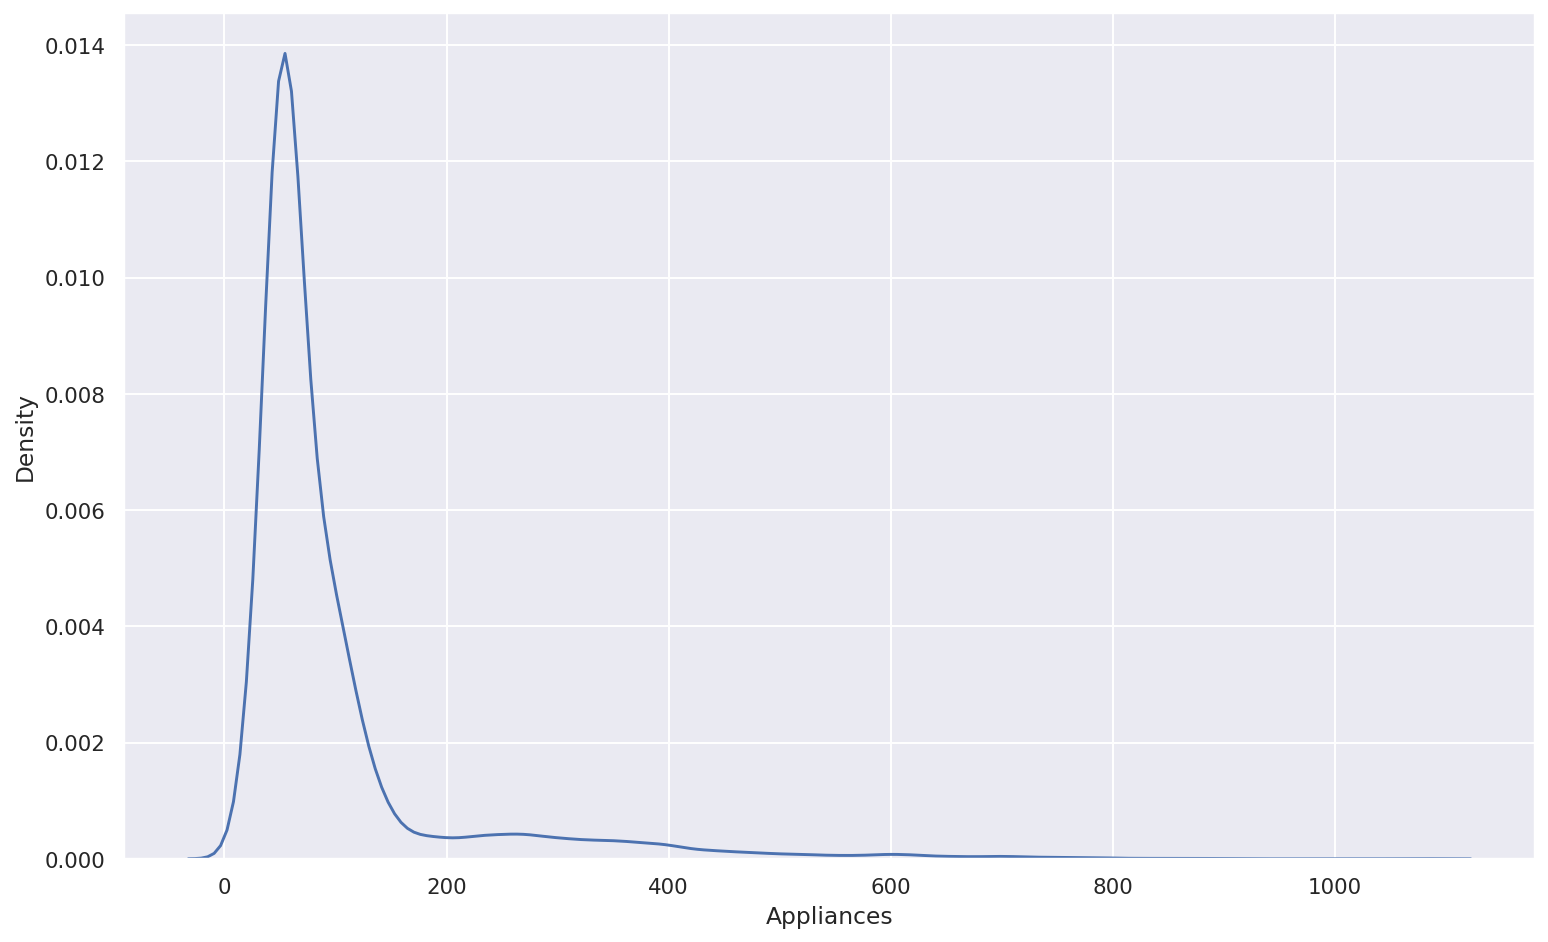

In [ ]:
sns.kdeplot(x="Appliances", data=df)

Let's look at both the autocorrelation and the partial autocorrelation plot. This can show us the covariance at different lag $\tau$ and help us in discover if the covariance holds the same.

Together with the AC and PAC plots, we display also two threshold denoted by dotted gray lines. These shows the threshold at which we can choose the optimal order of our model.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


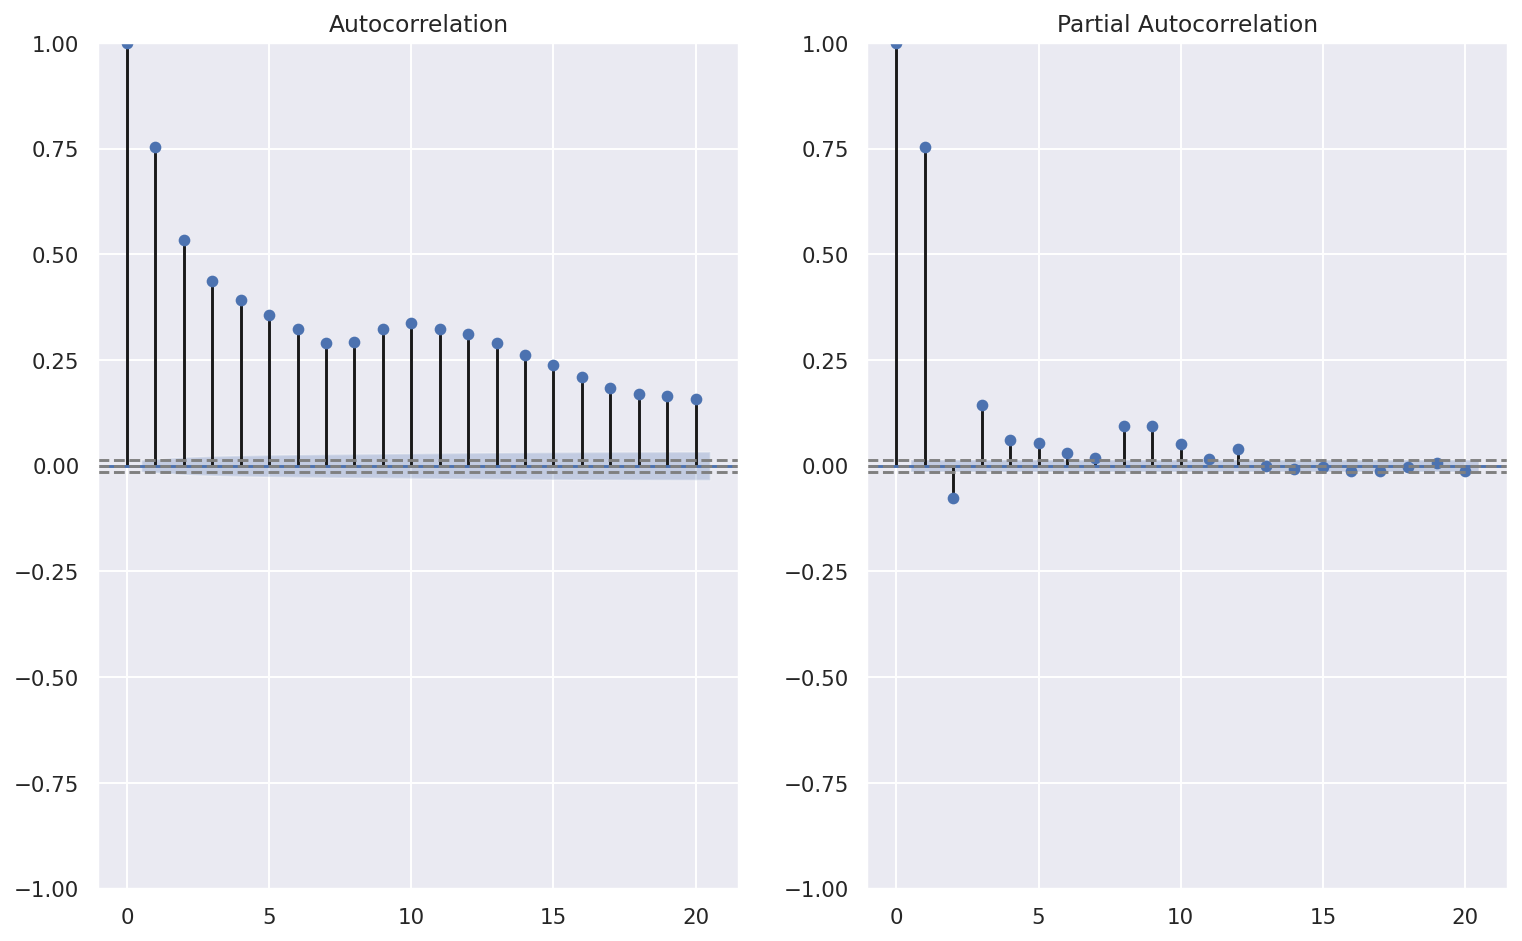

In [ ]:
fig, axes = plt.subplots(1,2)

# Putting lags to 40, we find that AR becomes 0 at 37
lags = 20

plot_acf(df["Appliances"], lags=lags, ax=axes[0])
axes[0].axhline(y=0,linestyle='--',color='gray')
axes[0].axhline(y=-1.96/np.sqrt(len(df["Appliances"])),linestyle='--',color='gray')
axes[0].axhline(y=1.96/np.sqrt(len(df["Appliances"])),linestyle='--',color='gray')

plot_pacf(df["Appliances"], lags=lags, ax=axes[1])
axes[1].axhline(y=0,linestyle='--',color='gray')
axes[1].axhline(y=-1.96/np.sqrt(len(df["Appliances"])),linestyle='--',color='gray')
axes[1].axhline(y=1.96/np.sqrt(len(df["Appliances"])),linestyle='--',color='gray')

As we can see moreover, the series seems to be stationary, with holding values of covariance from $\tau = 4$ going on.   
It seems clear that we can assume that the data is stationary. But we are always relying on assumptions based on observations.   
Let's rely on some statistical tests which can confirm us the stationarity with a certain degree of confidence.

## Statistical tests

### Normal_ad

The first test we look into is the __normal_ad__. This is a statistical test that aims to provide an answer to the following question:  

"Does the provided data comes from a Gaussian distribution?"   

Our time series data is compared against an arbitrary Gaussian distribution to test if data come from it.   
We try this test since we showed previously how the data seems to be Gaussian distributed.   
If the test confirm this claim, then we can also conclude that the time series is stationary, because an arbitrary Gaussian distribution has always a second order moment implying weakly stationary.    
References: https://www.asc.ohio-state.edu/de-jong.8/note1.pdf

In [ ]:
sm.stats.diagnostic.normal_ad(df["Appliances"].values)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/_adnorm.py:70: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


(inf, 0.0)

As we can see the __normal_ad__ test fails over our data. The returned p-value is 0.0, which is less than the confidence interval and so the data does not come from a Gaussian distribution.

To better assess the stationarity of our time series, we can perform a statistical test know as __KPSS__.

__KPSS__ test the time series against a null hypothesis that the time series is stationary around a deterministic trend, against the hypothesis that the time series has a unit root and so is non-stationary.

This test is more informative than the classical used of _adfuller_, since testing both the stationarity and unit root test, we can distinguish series that appear to be stationary, that appear to have a unit root and series which has not enough informative data to draw conclusions.

In [ ]:
# Set confidence interval
ALPHA = 0.05

# statsmodels - KPSS test
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable
def KPSS_statt(x):
     kpss_test = kpss(x)
     t_stat, p_value, _, critical_values  = kpss_test
     conclusion = "stationary" if p_value > ALPHA else "not stationary"
     res_dict = {"KPSS statistic":t_stat, "p-value":p_value, "should we difference?": (p_value < ALPHA), "conclusion": conclusion}
     return res_dict

# call the KPSS test:
resKPSS = KPSS_statt(df["Appliances"])

# print dictionary of test results:
print("KPSS test result for original data:")
[print(key, ":", value) for key,value in resKPSS.items()]

KPSS test result for original data:
KPSS statistic : 0.0365986672853029
p-value : 0.1
should we difference? : False
conclusion : stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


[None, None, None, None]

The p-value returned by the __KPSS__ test confirms our claim done on the stationarity assumption of our time series.

The returned p-value is greather than the confidence interval $\alpha$, resulting in a time series that is stationary.

We can conclude than that there are no linear trends in the series, and so we can perform the time series analysis using an ARMA model with a series that is stationary

## Data Splitting

First of all, we divde the data in two portions. Since we need to use 3 months for training and the remaining 1.5 for testing, we split the dataset based on the resulting percentage. We dropout the date column.

In [ ]:
split = 0.66

training_data, testing_data = np.split( df["Appliances"].values, [int(split*len(df))] )

In [ ]:
training_data

array([60, 60, 50, ..., 50, 50, 50])

In [ ]:
testing_data

array([ 60,  60,  60, ..., 270, 420, 430])

## ARIMA model

Now we fit the ARIMA model with the training data and test it over the test set. We collect the resulting predicted values and we measure the distance between the predicted values and test values.   
We select the orders of our model by looking at the autocorrelation plot, using the method known as Box-Jenkins method.   

As suggested by the literature, the partial autocorrelation plot of the AR(p) becomes 0 at lag p+1, while the autocorrelation plot of the MA(q) becomes 0 at lag q+1.

Referring to the Box-Jenkins method, we can see from the previous plots of the partial autocorrelation and autocorrelation that we have an _exponential/sinusoidal_ decay in the autocorrelation plot, while the partial autocorrelation plot shows a significant spike with lag $\tau = 1$, but none beyond lag $\tau > 1$.

From the above conclusions, we understand that our model is mostly autoregressive and not moving average, so we will try mostly only values of AR.

From the partial autocorrelation plot we can also estimate the optimal value for the $p$ parameters. This is given by the first lag $\tau$ that go beyond the upper confidence interval denoted by the gray dotted lines. We notice that this happens at $\tau = 2$ going on.

References: https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method

### Training and model selection

We evaluate all the different choices of the parameters of the ARIMA model over the training set, and then we store this results and we display the different metrics obtained.

We set also four error threshold which will be useful later for the predict and retrain phase.

In [ ]:
error_threshold = [0, 20, 50, 100]

# Create different combinations of parameters
parameters = []
for i in [2, 3, 5]:
  parameters.append((i, 0, 0))

for i in [2]:
  parameters.append((i, 0, 1))

print(parameters)

results_1st_training = {}

for error in error_threshold:
  # Training step: evaluate multiple model over the training_data, and collect the result, bic and aic score
  for i in tqdm(range(len(parameters))):
    model = pm.arima.ARIMA( order = parameters[i] )
    res = model.fit(training_data)
    # Save each fitted model indexed by the parameters tuple
    results_1st_training[parameters[i] + (error,)] = (res, res.aic(), res.bic())

    # Save results of training to object file
    a_file = open( os.path.join(basepath,"outputs/stationary/tr_results_{}_{}_{}_{}.pkl".format(parameters[i][0], parameters[i][1], parameters[i][2], error) ), "wb")
    pickle.dump({parameters[i] + (error,) : (res, res.aic(), res.bic())}, a_file)
    a_file.close()

# Look at first results
for key, val in results_1st_training.items():
  print("Model parameters: {}\naic score: {}\nbic score: {}\n".format(key, val[1], val[2]))

### Testing and retraining phase

For the testing phase, we decided to implement the following heuristic:
- For each of the previous trained models, we start predict values from the testing set.
- We measure the error between the obtained prediction and the true value.
- If the error is greater than the error threshold set, we count this as an error.
- When the model makes 5 consecutive errors, then a retraining phase starts, including all the passed instance in the test set. Instead if the model is able to guess the correct true value, we decrease the consecutive errors.

In [ ]:
next_results = {}

testing_results = {}

consequent_error = 0

# For all the obtained models
for key,val in results_1st_training.items():

  training_data2 = training_data
  
  error = key[3]

  predicted_values = []
  total_distances = []

  retraining_times = 0

  to_predict = 1

  for j in tqdm(range(len(testing_data))):
    # Predict next samples, from len(training_data)
    if retraining_times == 0:
      prediction = val[0].predict(start=len(training_data2)-1, end=len(training_data2)-1 + to_predict)
    else:
      prediction = res.predict(start=len(training_data2), end=len(training_data2) + to_predict)
      
    # Get last predictiob
    predicted_values.append(prediction[-1])

    dist = abs(testing_data[j] - prediction[-1])
    total_distances.append(dist)

    training_data2 = np.append(training_data2, testing_data[j])

    if dist > error:

      consequent_error += 1

      if consequent_error == 5:

        model = pm.arima.ARIMA( order=(key[0], key[1], key[2]), suppress_warnings=True )
        res = model.fit(training_data2)

        to_predict = 1

        retraining_times += 1

        consequent_error = 0

        next_results[(key[0], key[1], key[2], error)] = (res, res.aic(), res.bic()) 

      else:
        to_predict += 1

    else:
      to_predict += 1
      
      if consequent_error > 0:
        consequent_error -= 1

  # End inner for of testing
  # Save results of the actual ARIMA model
  testing_results[(key[0], key[1], key[2], error)] = { "distances": total_distances, "predicted": predicted_values, "retraining": retraining_times }

  print("Model terminated: {},{},{},{}".format(key[0], key[1], key[2], error))

  a2_file = open( os.path.join(basepath, "outputs/stationary/tr_ts_results_{}_{}_{}_{}.pkl".format(key[0], key[1], key[2], error)), "wb")
  pickle.dump({ (key[0], key[1], key[2], error): { "distances": total_distances, "predicted": predicted_values, "retraining": retraining_times } }, a2_file)
  a2_file.close()

  a3_file = open( os.path.join(basepath, "outputs/stationary/ts_results_{}_{}_{}_{}.pkl".format(key[0], key[1], key[2], error)), "wb")
  pickle.dump({ (key[0], key[1], key[2], error): { "distances": total_distances, "predicted": predicted_values, "retraining": retraining_times } }, a3_file)
  a3_file.close()


Since retraining and predict phase took very long time, we store every first training results, every retraining phase and all the results of the testing phase to Python object files, which will be useful later to perform analysis.

## Analysis

First, read results from the stored drive folder.

In [ ]:
tr_ts_results = {}
ts_results = {}

result_dir = os.path.join(basepath, "outputs/stationary/")

def read_text_file(file_path):
  if file_path.startswith("tr_ts_results"):
    with open(os.path.join(result_dir, file_path), 'rb') as f:
      tr_ts_results[file_path] = pickle.load(f)
  elif file_path.startswith("ts_results"):
    with open(os.path.join(result_dir, file_path), 'rb') as f:
      ts_results[file_path] = pickle.load(f)


# Read files from directory
files = os.listdir(result_dir)
for filename in files:
  read_text_file(filename)

tr_ts_results = collections.OrderedDict(sorted(tr_ts_results.items()))
ts_results = collections.OrderedDict(sorted(ts_results.items()))

Compute the different metrics based on the data collected

In [ ]:
from statsmodels.tsa.stattools import acf
import json

x_values = []
x_labels = []

y_values = []

i = 0

# Accuracy metrics
def forecast_accuracy(forecast, actual, retraining_times):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    y_values.append(mae)
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast, 
                              actual]))
    maxs = np.amax(np.hstack([forecast, 
                              actual]))
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast - actual)[1]            # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax, 'retraining': retraining_times})

for key,val in ts_results.items():
  values = key.split(".")
  info = values[0].split("_")
  predicted = next(iter(val.values()))["predicted"]
  retraining_times = next(iter(val.values()))["retraining"]
  print("Model: {},{},{},{}".format(info[2], info[3], info[4], info[5]))
  print(json.dumps(forecast_accuracy(predicted, testing_data, retraining_times), indent=2))
  x_values.append(i)
  i += 1
  x_labels.append("({},{},{},{})".format(info[2], info[3], info[4], info[5]))

Model: 2,0,0,0
{
  "mape": 0.6044154826124802,
  "me": 1.5625194045994564,
  "mae": 52.53007683229396,
  "mpe": 0.4366906025979878,
  "rmse": 92.04268540300792,
  "acf1": 0.7259817570746199,
  "corr": 0.4405826729259666,
  "minmax": 0.9770114942528736,
  "retraining": 1342
}
Model: 2,0,0,100
{
  "mape": 0.6981697271974147,
  "me": 8.148451622057285,
  "mae": 57.26598248755766,
  "mpe": 0.543134569135566,
  "rmse": 93.6317459226376,
  "acf1": 0.7342776168853754,
  "corr": 0.02507598751434864,
  "minmax": 0.9770114942528736,
  "retraining": 55
}
Model: 2,0,0,20
{
  "mape": 0.6053984449642227,
  "me": 1.7455464378484138,
  "mae": 52.54818152954679,
  "mpe": 0.4384838902244537,
  "rmse": 91.89769444303673,
  "acf1": 0.7255992910158139,
  "corr": 0.42222072046354553,
  "minmax": 0.9770114942528736,
  "retraining": 899
}
Model: 2,0,0,50
{
  "mape": 0.6243449149136048,
  "me": 2.903450059018269,
  "mae": 53.712125761331464,
  "mpe": 0.4581817910027813,
  "rmse": 92.55686393304599,
  "acf1": 0

Create a dataframe to display the different MAE's in a fashion way

In [ ]:
# Create a dataframe to display better the results
data = []

for i,j in zip(x_labels, y_values):
  res = tuple(map(int, i[1:-1].split(',')))
  # Append: (p,d,q), error, mae
  data.append([ (res[0], res[1], res[2]), res[3], j ])

df_res = pd.DataFrame(data, columns=['(p,d,q)', 'threshold', 'MAE'])

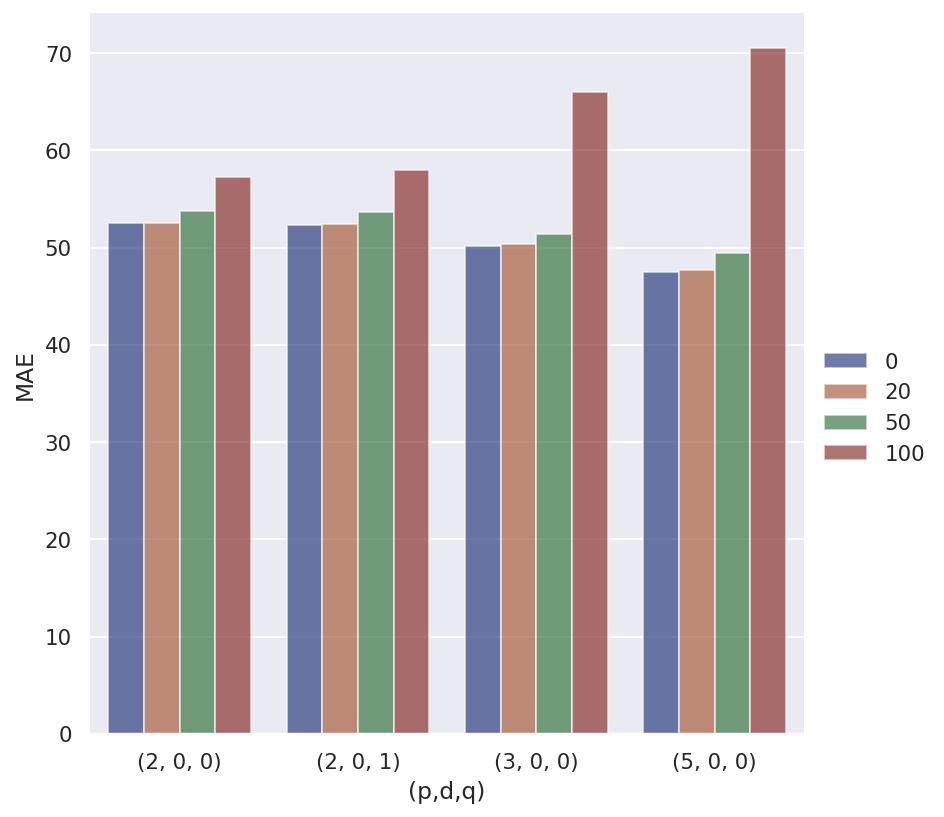

In [ ]:
# Draw a nested barplot error threshold
g = sns.catplot(
    data=df_res, kind="bar",
    x="(p,d,q)", y="MAE", hue="threshold",
    ci="sd", palette="dark", alpha=.6, height=6
)

g.despine(left=True)
g.set_axis_labels("(p,d,q)", "MAE")
g.legend.set_title("")

Plot the predicted data against the testing set

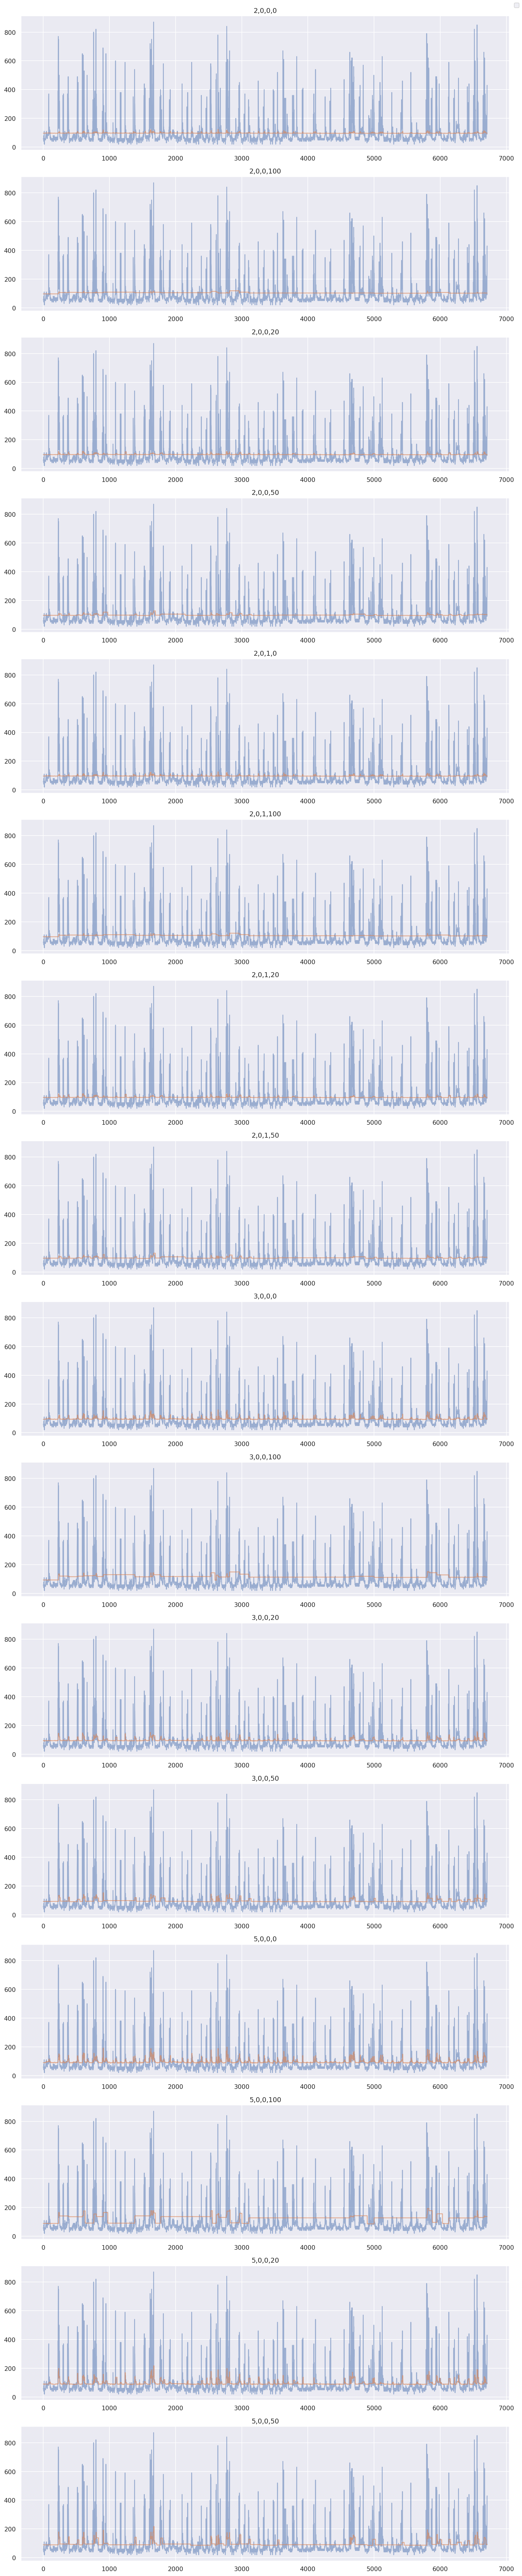

In [ ]:
fig, axes = plt.subplots( len(ts_results.keys()), 1, figsize=(13, len(ts_results.keys())*4 ))

i = 0

x = np.linspace(0, len(testing_data), len(testing_data))

palette = sns.color_palette("hls", 8)

for key,val in ts_results.items():
  values = key.split(".")
  info = values[0].split("_")
  predicted = next(iter(val.values()))["predicted"]

  sns.lineplot(x=x, y=testing_data, palette='dark', ax=axes[i], alpha=.5)
  sns.lineplot(x=x, y=predicted, palette='dark', ax=axes[i], alpha=.6)
  axes[i].title.set_text("{},{},{},{}".format(info[2], info[3], info[4], info[5]))
  i += 1

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)
fig.tight_layout(pad=1.0)

We can notice how the time series with the error threshold set to 0 approximate better the true timeseries. This is evident also by looking at the MAE values from the above barplot.   
The continuous retrain due to the error set to 0 benefits the prediction of the model, while in the more flexible timeseries the estimation is approximately constant.    
This is due to the fact that in those cases the ARMA model learn the intercept of the data and so whenever it needs to do a prediction it simply answer with the following value (it is a linear regression after all).    
Moreover we can see from the above bar plot that the best estimation is obtained with the higher value of $p$ set to $5$.

## Final consideration

In the end, we can conclude that the results are satisfactory. We obtained a MAE below 50 in the best case, by learning a linear regression on a sparse time series, where values are not constant.     
Also the predicted values follow a particular mean, this is due to the adopted heuristics of consequent errors. Using a continuous retrain after an immediate error would result in a better prediction.

The main weakness of the ARIMA model lies in the time required for the testing and retraining phase. In particular when increasing the order of $p$ and adding also a bit of moving average part, the model take a lot of time and does not complete even after the maximum runtime allowed.    

I used _auto_arima_ function to train and test an ARIMA model with order $p=2$ and $q=3$.    
After 12 hours of execution on Kaggle the testing and retraining phase was still at 40%.

# Non-stationary

## Non stationary setting

To make the time series non-stationary, we need to add an increasing linear trend in our data.

After this, we can run again the __KPSS__ test to check for stationarity.   
Based on what we learned from the Box-Jenkins method and literature online, when the time series is non-stationary we have three ways of proceeding:
- Subtract from the time series itself at each timestep $t$ the observation at the previous timestep $t-1$. Run again the __KPSS__ test to check for stationarity. If not, try again subtracting from the already obtained differences the previous timestep $t-2$.
- Use the second parameter provided by the pmdarima _ARIMA_ class. The parameter $d$, which stands for _differences_. It basicallies apply the same method described in the previous point, subtracting to the time series $d$ times.
- Compute a rolling mean and std with a window over the original time series and normalize the observations.

We will proceed by finding the optimal number of differences needed by subtracting previous values and then supply this value to the ARIMA model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
basepath = "/content/drive/MyDrive/LEZIONI AA 2020 21/ISPR/assignments/assignment1"

df = pd.read_csv(os.path.join(basepath, "energydata_complete.csv"))


df

date  Appliances  lights         T1       RH_1  \
0      2016-01-11 17:00:00          60      30  19.890000  47.596667   
1      2016-01-11 17:10:00          60      30  19.890000  46.693333   
2      2016-01-11 17:20:00          50      30  19.890000  46.300000   
3      2016-01-11 17:30:00          50      40  19.890000  46.066667   
4      2016-01-11 17:40:00          60      40  19.890000  46.333333   
...                    ...         ...     ...        ...        ...   
19730  2016-05-27 17:20:00         100       0  25.566667  46.560000   
19731  2016-05-27 17:30:00          90       0  25.500000  46.500000   
19732  2016-05-27 17:40:00         270      10  25.500000  46.596667   
19733  2016-05-27 17:50:00         420      10  25.500000  46.990000   
19734  2016-05-27 18:00:00         430      10  25.500000  46.600000   

              T2       RH_2         T3       RH_3         T4  ...         T9  \
0      19.200000  44.790000  19.790000  44.730000  19.000000  ...  17.033333   
1      19.200000  44.722500  19.790000  44.790000  19.000000  ...  17.066667   
2      19.200000  44.626667  19.790000  44.933333  18.926667  ...  17.000000   
3      19.200000  44.590000  19.790000  45.000000  18.890000  ...  17.000000   
4      19.200000  44.530000  19.790000  45.000000  18.890000  ...  17.000000   
...          ...        ...        ...        ...        ...  ...        ...   
19730  25.890000  42.025714  27.200000  41.163333  24.700000  ...  23.200000   
19731  25.754000  42.080000  27.133333  41.223333  24.700000  ...  23.200000   
19732  25.628571  42.768571  27.050000  41.690000  24.700000  ...  23.200000   
19733  25.414000  43.036000  26.890000  41.290000  24.700000  ...  23.200000   
19734  25.264286  42.971429  26.823333  41.156667  24.700000  ...  23.200000   

          RH_9      T_out  Press_mm_hg     RH_out  Windspeed  Visibility  \
0      45.5300   6.600000        733.5  92.000000   7.000000   63.000000   
1      45.5600   6.483333        733.6  92.000000   6.666667   59.166667   
2      45.5000   6.366667        733.7  92.000000   6.333333   55.333333   
3      45.4000   6.250000        733.8  92.000000   6.000000   51.500000   
4      45.4000   6.133333        733.9  92.000000   5.666667   47.666667   
...        ...        ...          ...        ...        ...         ...   
19730  46.7900  22.733333        755.2  55.666667   3.333333   23.666667   
19731  46.7900  22.600000        755.2  56.000000   3.500000   24.500000   
19732  46.7900  22.466667        755.2  56.333333   3.666667   25.333333   
19733  46.8175  22.333333        755.2  56.666667   3.833333   26.166667   
19734  46.8450  22.200000        755.2  57.000000   4.000000   27.000000   

       Tdewpoint        rv1        rv2  
0       5.300000  13.275433  13.275433  
1       5.200000  18.606195  18.606195  
2       5.100000  28.642668  28.642668  
3       5.000000  45.410389  45.410389  
4       4.900000  10.084097  10.084097  
...          ...        ...        ...  
19730  13.333333  43.096812  43.096812  
19731  13.300000  49.282940  49.282940  
19732  13.266667  29.199117  29.199117  
19733  13.233333   6.322784   6.322784  
19734  13.200000  34.118851  34.118851  

[19735 rows x 29 columns]

In [ ]:
df["date"] = pd.to_datetime(df["date"])

df = df.iloc[:, 0:2]

df = df.sort_values(by="date")

df

df2 = df.copy()

### Linear trend

Let's add a linear trend to the time series.    
Given the dataset length $N$ and an integer $i = 0,\ldots,N-1$, we add to each item 

$\frac{\sqrt{N}}{N} \cdot i$

based on its position $i$ in the dataset.

In [ ]:
N = len(df2)

def increase(idx,N):
  return idx * np.sqrt(N) / N

for idx, row in df2.iterrows():
  df2.loc[idx, "Appliances"] = int(row.Appliances + increase(idx,N))

In [ ]:
df2["Appliances"]

0         60
1         60
2         50
3         50
4         60
        ... 
19730    240
19731    230
19732    410
19733    560
19734    570
Name: Appliances, Length: 19735, dtype: int64

Now we run again the __KPSS__ test over the modified timeseries to estimate the stationarity.

In [ ]:
# Set confidence interval
ALPHA = 0.05

# statsmodels - KPSS test
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable
def KPSS_statt(x):
     kpss_test = kpss(x)
     t_stat, p_value, _, critical_values  = kpss_test
     conclusion = "stationary" if p_value > ALPHA else "not stationary"
     res_dict = {"KPSS statistic":t_stat, "p-value":p_value, "should we difference?": (p_value < ALPHA), "conclusion": conclusion}
     return res_dict

# call the KPSS test:
resKPSS = KPSS_statt(df2["Appliances"])

# print dictionary of test results:
print("KPSS test result for original data:")
[print(key, ":", value) for key,value in resKPSS.items()]

KPSS test result for original data:
KPSS statistic : 11.869695704883178
p-value : 0.01
should we difference? : True
conclusion : not stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


[None, None, None, None]

As we can immediately see, the result of the __KPSS__ test confirm us the non stationarity of the time series. The _p-value_ is less than our confidence interval $\alpha$, and so we have to make our time series stationary.

We can apply subtraction between a timestep $t$ and the previos $t-1$ to make it stationary.

In [ ]:
shifted_data = df2["Appliances"] - df2["Appliances"].shift(periods=1)

shifted_data.dropna(inplace=True)

After differencing the time series with a shift of 1 period, we apply again the __KPSS__ test.

In [ ]:
# call the KPSS test:
resKPSS = KPSS_statt(shifted_data)

# print dictionary of test results:
print("KPSS test result for original data:")
[print(key, ":", value) for key,value in resKPSS.items()]

KPSS test result for original data:
KPSS statistic : 0.04601846220168666
p-value : 0.1
should we difference? : False
conclusion : stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


[None, None, None, None]

As we can see the __KPSS__ test now returns us a stationary estimation. With an order of differencing of 1 we have obtained again a stationary time series. We can proceed now in two ways:
- Provide the shifted time series again to the ARIMA model with the previous orders $p, d, q$;
- Provide directly the non stationary data to the ARIMA model with the same orders for $p$ and $q$, but putting now in each configuration the parameter $d = 1$. In this way the model takes into account the non stationarity of the time series and apply the same difference we applied before, making it stationary.

## Data Splitting

First of all, we divde the data in two portions. Since we need to use 3 months for training and the remaining 1.5 for testing, we split the dataset based on the resulting percentage. We dropout the date column

In [ ]:
split = 0.66

training_data, testing_data = np.split( df2["Appliances"].values, [int(split*len(df))] )

In [ ]:
training_data

array([ 60,  60,  50, ..., 142, 142, 142])

In [ ]:
testing_data

array([152, 152, 152, ..., 410, 560, 570])

## Training, testing and retraining phase

All the mechanism for training, retraining and testing explained in the stationary case is used likewise for the non stationary case.

In [ ]:
error_threshold = [0, 20, 50, 100]

# Create different combinations of parameters
parameters = []
for i in [2, 3, 5]:
    parameters.append((i, 1, 0))

for i in [2]:
    parameters.append((i, 1, 1))

print(parameters)

results_1st_training = {}

for error in error_threshold:
  # Training step: evaluate multiple model over the training_data, and collect the result, bic and aic score
  for i in tqdm(range(len(parameters))):
    model = pm.arima.ARIMA( order = parameters[i] )
    res = model.fit(training_data)
    # Save each fitted model indexed by the parameters tuple
    results_1st_training[parameters[i] + (error,)] = (res, res.aic(), res.bic())

    # Save results of training to object file
    a_file = open( os.path.join(basepath, "outputs/nonstationary/tr_results_{}_{}_{}_{}.pkl".format(parameters[i][0], parameters[i][1], parameters[i][2], error)), "wb")
    pickle.dump({parameters[i] + (error,) : (res, res.aic(), res.bic())}, a_file)
    a_file.close()

# Look at first results
for key, val in results_1st_training.items():
    print("Model parameters: {}\naic score: {}\nbic score: {}\n".format(key, val[1], val[2]))

In [ ]:
next_results = {}

testing_results = {}

consequent_error = 0

# For all the obtained models
for key,val in results_1st_training.items():

  training_data2 = training_data
  
  error = key[3]

  predicted_values = []
  total_distances = []

  retraining_times = 0

  to_predict = 1

  for j in tqdm(range(len(testing_data))):
    # Predict next samples, from len(training_data)
    if retraining_times == 0:
      prediction = val[0].predict(start=len(training_data2), end=len(training_data2) + to_predict)
    else:
      prediction = res.predict(start=len(training_data2), end=len(training_data2) + to_predict)
      
    predicted_values.append(prediction[-1])

    dist = abs(testing_data[j] - prediction[-1])
    total_distances.append(dist)

    training_data2 = np.append(training_data2, testing_data[j])

    if dist > error:

      consequent_error += 1

      if consequent_error == 5:

        model = pm.arima.ARIMA( order=(key[0], key[1], key[2]) )
        res = model.fit(training_data2)

        to_predict = 1

        retraining_times += 1

        consequent_error = 0

        next_results[(key[0], key[1], key[2], error)] = (res, res.aic(), res.bic()) 

      else:
        to_predict += 1

    else:
      to_predict += 1
      
      if consequent_error > 0:
        consequent_error -= 1

  # End inner for of testing
  # Save results of the actual ARIMA model
  testing_results[(key[0], key[1], key[2], error)] = { "distances": total_distances, "predicted": predicted_values, "retraining": retraining_times }

  print("Model terminated: {},{},{},{}".format(key[0], key[1], key[2], error))

  a2_file = open( os.path.join(basepath, "outputs/nonstationary/tr_ts_results_{}_{}_{}_{}.pkl".format(key[0], key[1], key[2], error)), "wb")
  pickle.dump({ (key[0], key[1], key[2], error): { "distances": total_distances, "predicted": predicted_values, "retraining": retraining_times } }, a2_file)
  a2_file.close()

  a3_file = open( os.path.join(basepath, "outputs/nonstationary/ts_results_{}_{}_{}_{}.pkl".format(key[0], key[1], key[2], error)), "wb")
  pickle.dump({ (key[0], key[1], key[2], error): { "distances": total_distances, "predicted": predicted_values, "retraining": retraining_times } }, a3_file)
  a3_file.close()


## Analysis

First, read results from the stored drive folder.

In [ ]:
tr_ts_results = {}
ts_results = {}

result_dir = os.path.join(basepath, "outputs/nonstationary/")

def read_text_file(file_path):
  if file_path.startswith("tr_ts_results"):
    with open(os.path.join(result_dir, file_path), 'rb') as f:
      tr_ts_results[file_path] = pickle.load(f)
  elif file_path.startswith("ts_results"):
    with open(os.path.join(result_dir, file_path), 'rb') as f:
      ts_results[file_path] = pickle.load(f)


files = os.listdir(result_dir)
for filename in files:
  read_text_file(filename)

tr_ts_results = collections.OrderedDict(sorted(tr_ts_results.items()))
ts_results = collections.OrderedDict(sorted(ts_results.items()))

Compute the different metrics based on the data collected

In [ ]:
from statsmodels.tsa.stattools import acf
import json

x_values = []
x_labels = []

y_values = []

i = 0

# Accuracy metrics
def forecast_accuracy(forecast, actual, retraining_times):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    y_values.append(mae)
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast, 
                              actual]))
    maxs = np.amax(np.hstack([forecast, 
                              actual]))
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast - actual)[1]            # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax, 'retraining': retraining_times})

for key,val in ts_results.items():
  values = key.split(".")
  info = values[0].split("_")
  predicted = next(iter(val.values()))["predicted"]
  retraining_times = next(iter(val.values()))["retraining"]
  print("Model: {},{},{},{}".format(info[2], info[3], info[4], info[5]))
  print(json.dumps(forecast_accuracy(predicted, testing_data, retraining_times), indent=2))
  x_values.append(i)
  i += 1
  x_labels.append("({},{},{},{})".format(info[2], info[3], info[4], info[5]))

Model: 2,1,0,0
{
  "mape": 0.1442819889533474,
  "me": -1.3992750974350876,
  "mae": 39.64577766041226,
  "mpe": 0.034601168895015785,
  "rmse": 89.15537622998737,
  "acf1": 0.5729755956251068,
  "corr": 0.4996065484787297,
  "minmax": 0.8867542972699697,
  "retraining": 1342
}
Model: 2,1,0,100
{
  "mape": 0.26674891416809887,
  "me": 20.233193156009904,
  "mae": 60.41503067915118,
  "mpe": 0.172292397901745,
  "rmse": 96.98272406594951,
  "acf1": 0.67796475513423,
  "corr": 0.3595320352130261,
  "minmax": 0.8867542972699697,
  "retraining": 83
}
Model: 2,1,0,20
{
  "mape": 0.13765553474985887,
  "me": -6.13040752187678,
  "mae": 38.395653096183175,
  "mpe": 0.01477818870858122,
  "rmse": 87.87224116143486,
  "acf1": 0.5946980961065691,
  "corr": 0.5043669104267707,
  "minmax": 0.8867542972699697,
  "retraining": 291
}
Model: 2,1,0,50
{
  "mape": 0.17440723402796163,
  "me": -2.302989944321961,
  "mae": 45.485191832447846,
  "mpe": 0.043916822848590914,
  "rmse": 92.95476818436273,
  "

Create a DataFrame to display the MAE's in a stylish way


In [ ]:
# Create a dataframe to display better the results
data = []

for i,j in zip(x_labels, y_values):
  res = tuple(map(int, i[1:-1].split(',')))
  # Append: (p,d,q), error, mae
  data.append([ (res[0], res[1], res[2]), res[3], j ])

df_res = pd.DataFrame(data, columns=['(p,d,q)', 'threshold', 'MAE'])

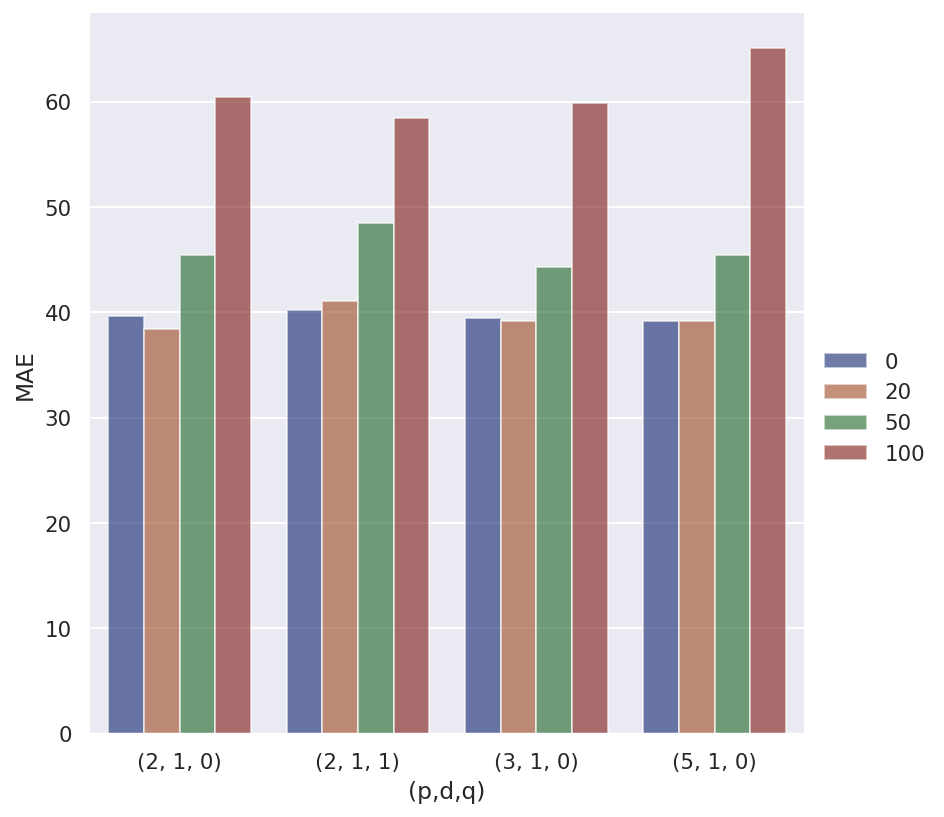

In [ ]:
# Draw a nested barplot by error threshold
g = sns.catplot(
    data=df_res, kind="bar",
    x="(p,d,q)", y="MAE", hue="threshold",
    ci="sd", palette="dark", alpha=.6, height=6
)

g.despine(left=True)
g.set_axis_labels("(p,d,q)", "MAE")
g.legend.set_title("")

Plot the predicted data against the testing set

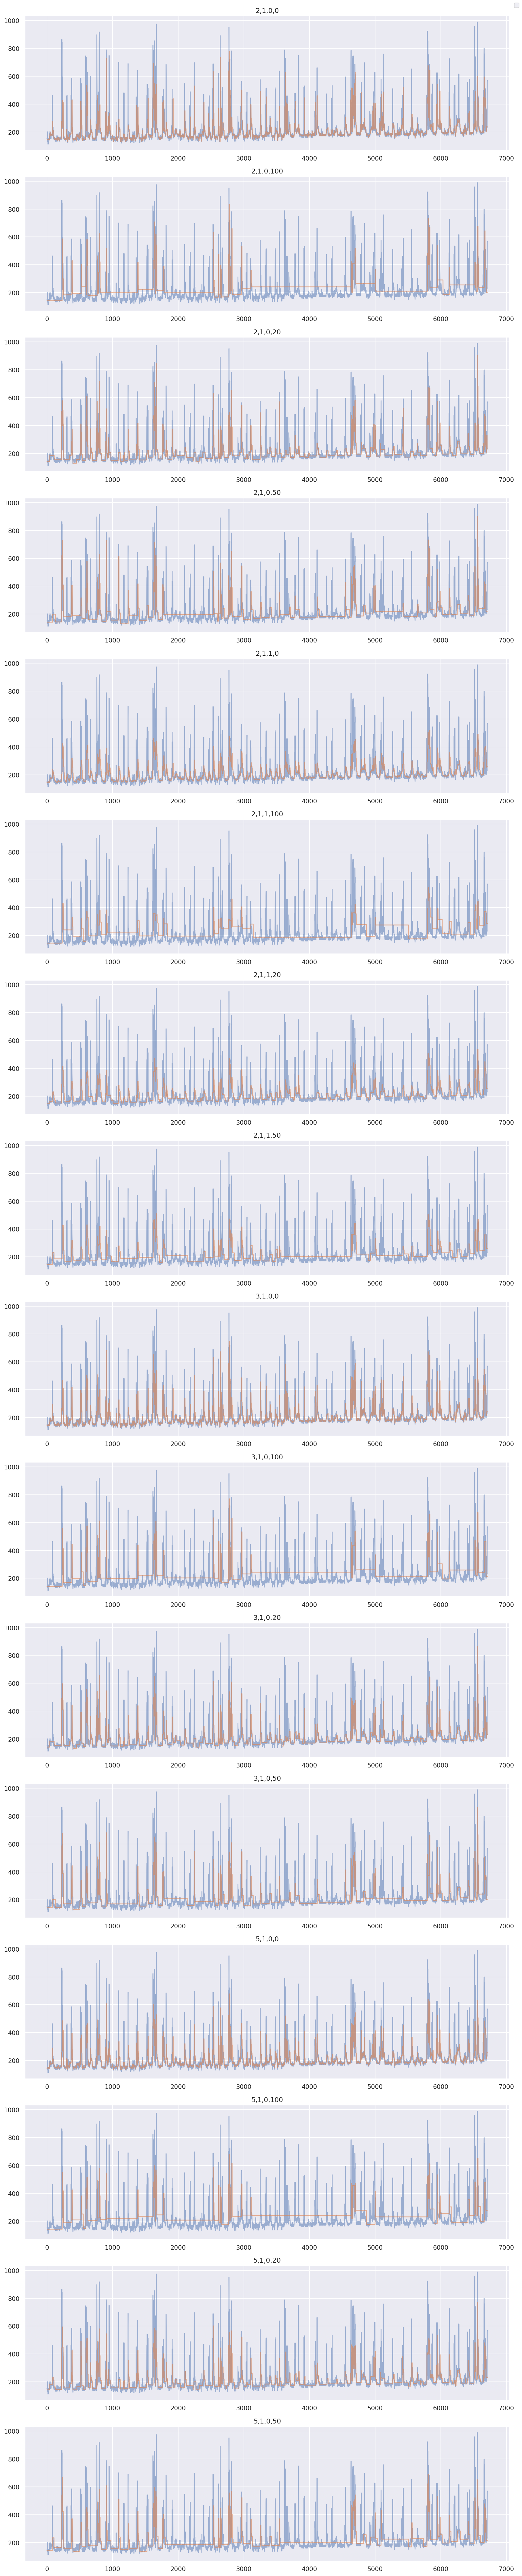

In [ ]:
fig, axes = plt.subplots( len(ts_results.keys()), 1, figsize=(13, len(ts_results.keys())*4 ))

i = 0

x = np.linspace(0, len(testing_data), len(testing_data))

palette = sns.color_palette("hls", 8)

for key,val in ts_results.items():
  values = key.split(".")
  info = values[0].split("_")
  predicted = next(iter(val.values()))["predicted"]

  sns.lineplot(x=x, y=testing_data, palette='dark', ax=axes[i], alpha=.5)
  sns.lineplot(x=x, y=predicted, palette='dark', ax=axes[i], alpha=.6)
  axes[i].title.set_text("{},{},{},{}".format(info[2], info[3], info[4], info[5]))
  i += 1

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)
fig.tight_layout(pad=1.0)

In the non stationary case, we can see both from the time series predicted and the MAE errors that the time series is predicted way better than the stationary case.   
Setting the parameter $d$ to 1 and letting the ARMA model do the first order differencing, we obtain good predictions and lower MAE when the error threshold is low. Compared to the stationary case, here the MAE increase vertiginously when we use an high error threshold, while in the other case the MAE does not have an abrupt peak of increase.   
We can see also from the barplot how the different orders of the ARIMA models tested behave moreover the same, and consequently also the predicted values benefit of this.

## Final consideration

In the end, we can conclude that the results are satisfactory. We obtained a better MAE below 40 in this case, by learning a linear regression on a non stationary time series.     
Compared to the stationary case, here we can see that the results obtained on the predicted values of the time series are better. The predictions match better with the true values.    
Also in this case we can imagine how removing the chosen heuristics of the consequent errors would bring an improvement over the predictions and the overall MAE.

As said for the stationary case, the main weakness of the ARIMA model is the time required for the testing and retraining phase.    
Using a more complex model with higher order of $p$ and also some order of $q$ does not complete even after 12 hours of execution (like in stationary case).